<a href="https://colab.research.google.com/github/dsk-yshkw/DataDrivenFinance/blob/main/ch09_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データの整理

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## データをyfinanceを使って準備する場合


In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.5 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override() 

In [ ]:
target = '7203.T'
symbols = ('1306.T',target)
df = pd.DataFrame()
for symbol in symbols:
    data = pdr.get_data_yahoo(symbol, 
                              start="2016-03-30", 
                              end="2021-03-31")['Adj Close']
    data.name = symbol
    df = pd.concat([df,data],axis = 1)

for i in np.arange(len(df.index)):
    df.index.values[i] = str(df.index[i].date())

df.index = df.index.rename('Date')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
df = df.dropna()
df


,1306.T,7203.T
Date,,
2016-03-30,1407.0,898.201355
2016-03-31,1397.0,891.015686
2016-04-01,1346.0,863.919861
2016-04-04,1350.0,842.063721
2016-04-05,1314.0,814.219543
...,...,...
2021-03-25,2033.0,1512.630493
2021-03-26,2066.0,1550.089355
2021-03-29,2068.0,1569.745850


## CSVからのデータ取得

In [ ]:
# GitHubからダウンロードしたzipファイルを展開し，そのままローカルで使う場合
df = pd.read_csv("ch09_stock_price.csv",index_col = 'Date')

# Google Colabを使用し，sample_dataフォルダにcsvファイルを置いた場合
#df = pd.read_csv("sample_data/ch09_stock_price.csv",index_col = 'Date')

# Google ColabとGoogle Driveを併用し，MyDrive下に作った以下のようなサブフォルダにcsvファイルを置いた場合
#df = pd.read_csv("drive/MyDrive/Colab Notebooks/Kyoritsu/ch09_stock_price.csv",index_col = 'Date')


## データの整理

In [ ]:
df_rate = pd.DataFrame()
df_rate['TOPIX 1 day return'] = df['1306.T'].pct_change()
df_rate['7203 1 day return'] = df['7203.T'].pct_change()
df_rate = df_rate.dropna()
df_rate['diff'] =  df_rate['7203 1 day return'].shift(-1)\
                - df_rate['TOPIX 1 day return'].shift(-1)
df_rate['target'] = (df_rate['diff'] > 0).astype(int)
df_rate = df_rate.dropna()
df_rate


,TOPIX 1 day return,7203 1 day return,diff,target
Date,,,,
2016-03-31,-0.007107,-0.008000,0.006097,1
2016-04-01,-0.036507,-0.030410,-0.028271,0
2016-04-04,0.002972,-0.025299,-0.006400,0
2016-04-05,-0.026667,-0.033067,0.003309,1
2016-04-06,0.000000,0.003309,-0.009852,0
...,...,...,...,...
2021-03-24,-0.020955,-0.022158,-0.007390,0
2021-03-25,0.011946,0.004557,0.008532,1
2021-03-26,0.016232,0.024764,0.011713,1


In [ ]:
diffs = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,40,60,80,100,120,\
         140,160,180,200,220,240]
    
for diff in diffs:
    df_rate['TOPIX ' + str(diff) + ' days return'] = df['1306.T'].pct_change(diff)
    df_rate['7203 ' + str(diff) + ' days return'] = df['7203.T'].pct_change(diff)

df_rate = df_rate.dropna(how = 'any')

In [ ]:
X = df_rate[df_rate.columns[(df_rate.columns != 'diff') 
                            & (df_rate.columns != 'target')]]
y = df_rate['target']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
val_size = 0.2

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = val_size,shuffle = False)

# Kerasによるディープラーニング

## ロジスティック回帰

In [ ]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
log_reg = linear_model.LogisticRegression(random_state=0)
log_reg.fit(X_train,y_train)

y_pred = log_reg.predict(X_train)
print('accuracy score for train data', accuracy_score(y_train,y_pred))

y_val_pred = log_reg.predict(X_val)
print('accuracy score for valid data', accuracy_score(y_val,y_val_pred))

accuracy score for train data 0.5775
accuracy score for valid data 0.4975124378109453


## ディープラーニング

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

In [ ]:
model = Sequential()
model.add(Dense(units = 62, activation = 'sigmoid'))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
optimizer = optimizers.SGD(learning_rate = 0.05)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [ ]:
tf.random.set_seed(0)
model.fit(X_train.values,y_train.values,
                    epochs = 100, batch_size = 1,verbose = 2,
                    validation_data = (X_val.values,y_val.values))


Epoch 1/100
800/800 - 3s - loss: 0.7508 - accuracy: 0.5113 - val_loss: 0.6859 - val_accuracy: 0.5622 - 3s/epoch - 4ms/step
Epoch 2/100
800/800 - 1s - loss: 0.7455 - accuracy: 0.5088 - val_loss: 0.7301 - val_accuracy: 0.5622 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.7527 - accuracy: 0.4863 - val_loss: 0.7139 - val_accuracy: 0.4428 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.7392 - accuracy: 0.5000 - val_loss: 0.7068 - val_accuracy: 0.5622 - 1s/epoch - 2ms/step
Epoch 5/100
800/800 - 1s - loss: 0.7471 - accuracy: 0.4913 - val_loss: 0.6943 - val_accuracy: 0.5124 - 1s/epoch - 2ms/step
Epoch 6/100
800/800 - 1s - loss: 0.7441 - accuracy: 0.4888 - val_loss: 0.6844 - val_accuracy: 0.5771 - 1s/epoch - 2ms/step
Epoch 7/100
800/800 - 1s - loss: 0.7276 - accuracy: 0.5425 - val_loss: 0.6894 - val_accuracy: 0.5373 - 1s/epoch - 2ms/step
Epoch 8/100
800/800 - 1s - loss: 0.7324 - accuracy: 0.5013 - val_loss: 0.7544 - val_accuracy: 0.4378 - 1s/epoch - 2ms/step
Epoch 9/100
800/

In [ ]:
score_train = model.evaluate(X_train.values,y_train.values,verbose = 0)
score_val = model.evaluate(X_val.values,y_val.values,verbose = 0)
print('accuracy for train data',score_train[1])
print('accuracy for validation data',score_val[1])

accuracy for train data 0.5649999976158142
accuracy for validation data 0.4726368188858032


# 学習方法の改善

## 早期終了  

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()
model.add(Dense(units = 62,activation = 'sigmoid'))
model.add(Dense(1,activation = 'sigmoid'))
optimizer = optimizers.SGD(learning_rate = 0.05)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy',
             metrics = ['accuracy'])
tf.random.set_seed(0)
es = EarlyStopping(monitor = 'loss',
                  patience = 30)
model.fit(X_train.values,y_train.values,
         epochs = 4000, batch_size = 1,verbose = 2,
         callbacks = [es],
         validation_data = (X_val,y_val))


Epoch 1/4000
800/800 - 2s - loss: 0.7508 - accuracy: 0.5125 - val_loss: 0.6859 - val_accuracy: 0.5622 - 2s/epoch - 2ms/step
Epoch 2/4000
800/800 - 1s - loss: 0.7455 - accuracy: 0.5088 - val_loss: 0.7301 - val_accuracy: 0.5622 - 993ms/epoch - 1ms/step
Epoch 3/4000
800/800 - 1s - loss: 0.7527 - accuracy: 0.4863 - val_loss: 0.7139 - val_accuracy: 0.4428 - 988ms/epoch - 1ms/step
Epoch 4/4000
800/800 - 1s - loss: 0.7392 - accuracy: 0.5000 - val_loss: 0.7068 - val_accuracy: 0.5622 - 998ms/epoch - 1ms/step
Epoch 5/4000
800/800 - 1s - loss: 0.7471 - accuracy: 0.4913 - val_loss: 0.6943 - val_accuracy: 0.5124 - 1s/epoch - 1ms/step
Epoch 6/4000
800/800 - 1s - loss: 0.7441 - accuracy: 0.4888 - val_loss: 0.6844 - val_accuracy: 0.5771 - 1s/epoch - 1ms/step
Epoch 7/4000
800/800 - 1s - loss: 0.7276 - accuracy: 0.5425 - val_loss: 0.6894 - val_accuracy: 0.5373 - 1s/epoch - 1ms/step
Epoch 8/4000
800/800 - 1s - loss: 0.7324 - accuracy: 0.5013 - val_loss: 0.7544 - val_accuracy: 0.4378 - 981ms/epoch - 1ms/s

In [ ]:
score_train = model.evaluate(X_train.values,y_train.values,verbose = 0)
score_val = model.evaluate(X_val.values,y_val.values,verbose = 0)
print('accuracy for train data',score_train[1])
print('accuracy for validation data',score_val[1])

accuracy for train data 0.5625
accuracy for validation data 0.4875621795654297


## 最適化手法 

### モーメンタム最適化

In [ ]:
optimizer = optimizers.SGD(learning_rate = 0.05, momentum = 0.9)

### NAG (Nesterov accelarated gradient) 

In [ ]:
optimizer = optimizers.SGD(learning_rate = 0.05, 
                           momentum = 0.9, 
                           nesterov = True)

### Adagrad 

In [ ]:
optimizer = optimizers.Adagrad(learning_rate = 0.05)

### RMSprop 

In [ ]:
optimizer = optimizers.RMSprop(learning_rate = 0.001,rho=0.99)

### Adam

In [ ]:
optimizer = optimizers.Adam(learning_rate = 0.001, 
                            beta_1 = 0.9, 
                            beta_2 = 0.999)

In [ ]:
# Adadelta, RMSpropと同様にパラメータを与えればよい
optimizer = optimizers.Adadelta(rho = 0.95) 
# AMSGrad, Adamの改良版なので，amsgrad = True とする以外はAdamと同じである．
optimizer = optimizers.Adam(learning_rate = 0.001,  
                            beta_1 = 0.9, 
                            beta_2 = 0.999, 
                            amsgrad = True) 
# AdaMax, Adamと同様にパラメータを与えればよい．
optimizer = optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999) 
# Nadam，Adamと同様にパラメータを与えればよい．
optimizer = optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## RMSpropを使った例

In [ ]:
tf.random.set_seed(0)
model = Sequential()
model.add(Dense(units = 62,activation = 'sigmoid'))
model.add(Dense(1,activation = 'sigmoid'))
optimizer = optimizers.RMSprop(learning_rate = 0.05,rho=0.95)
model.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
es = EarlyStopping(monitor = 'loss',
                  patience = 30,
                  verbose = 1)
model.fit(X_train.values,y_train.values,
         epochs = 10000, batch_size = 1,verbose = 2,
         callbacks = [es],
         validation_data = (X_val,y_val))

Epoch 1/10000
800/800 - 2s - loss: 0.7627 - accuracy: 0.5288 - val_loss: 0.6814 - val_accuracy: 0.5423 - 2s/epoch - 2ms/step
Epoch 2/10000
800/800 - 1s - loss: 0.7393 - accuracy: 0.5337 - val_loss: 0.6775 - val_accuracy: 0.5821 - 1s/epoch - 1ms/step
Epoch 3/10000
800/800 - 1s - loss: 0.7098 - accuracy: 0.5437 - val_loss: 0.8272 - val_accuracy: 0.4378 - 1s/epoch - 2ms/step
Epoch 4/10000
800/800 - 1s - loss: 0.7192 - accuracy: 0.5150 - val_loss: 0.7278 - val_accuracy: 0.5473 - 1s/epoch - 1ms/step
Epoch 5/10000
800/800 - 1s - loss: 0.7159 - accuracy: 0.5525 - val_loss: 1.1285 - val_accuracy: 0.4925 - 1s/epoch - 1ms/step
Epoch 6/10000
800/800 - 1s - loss: 0.7195 - accuracy: 0.5575 - val_loss: 0.7234 - val_accuracy: 0.5572 - 1s/epoch - 1ms/step
Epoch 7/10000
800/800 - 1s - loss: 0.7136 - accuracy: 0.5713 - val_loss: 0.8462 - val_accuracy: 0.5174 - 1s/epoch - 1ms/step
Epoch 8/10000
800/800 - 1s - loss: 0.7036 - accuracy: 0.5512 - val_loss: 1.0302 - val_accuracy: 0.5174 - 1s/epoch - 1ms/step


In [ ]:
score_train = model.evaluate(X_train.values,y_train.values,verbose = 0)
score_val = model.evaluate(X_val.values,y_val.values,verbose = 0)
print('accuracy for train data',score_train[1])
print('accuracy for validation data',score_val[1])

accuracy for train data 0.9237499833106995
accuracy for validation data 0.5074626803398132


# 勾配消失問題 

In [ ]:
model = Sequential()
model.add(Dense(units = 62,activation = 'sigmoid'))
model.add(Dense(units = 62,activation = 'sigmoid'))
model.add(Dense(units = 62,activation = 'sigmoid'))
model.add(Dense(units = 62,activation = 'sigmoid'))
model.add(Dense(units = 62,activation = 'sigmoid'))
model.add(Dense(1,activation = 'sigmoid'))
optimizer = optimizers.SGD(learning_rate = 0.05)
model.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
tf.random.set_seed(0)
es = EarlyStopping(monitor = 'loss',
                  patience = 30,
                  verbose = 1)
model.fit(X_train.values,y_train.values,
          epochs = 10000, batch_size = 10,verbose = 2,
          callbacks = [es],
          validation_data = (X_val.values,y_val.values))

Epoch 1/10000
80/80 - 1s - loss: 0.7020 - accuracy: 0.5213 - val_loss: 0.6859 - val_accuracy: 0.5622 - 1s/epoch - 17ms/step
Epoch 2/10000
80/80 - 0s - loss: 0.6954 - accuracy: 0.5188 - val_loss: 0.6891 - val_accuracy: 0.5622 - 225ms/epoch - 3ms/step
Epoch 3/10000
80/80 - 0s - loss: 0.6946 - accuracy: 0.5337 - val_loss: 0.7091 - val_accuracy: 0.4378 - 207ms/epoch - 3ms/step
Epoch 4/10000
80/80 - 0s - loss: 0.7018 - accuracy: 0.4787 - val_loss: 0.6854 - val_accuracy: 0.5622 - 174ms/epoch - 2ms/step
Epoch 5/10000
80/80 - 0s - loss: 0.6976 - accuracy: 0.5013 - val_loss: 0.6934 - val_accuracy: 0.4378 - 213ms/epoch - 3ms/step
Epoch 6/10000
80/80 - 0s - loss: 0.6973 - accuracy: 0.5163 - val_loss: 0.6931 - val_accuracy: 0.5622 - 235ms/epoch - 3ms/step
Epoch 7/10000
80/80 - 0s - loss: 0.6978 - accuracy: 0.5138 - val_loss: 0.6919 - val_accuracy: 0.5622 - 190ms/epoch - 2ms/step
Epoch 8/10000
80/80 - 0s - loss: 0.6962 - accuracy: 0.5163 - val_loss: 0.6905 - val_accuracy: 0.5622 - 234ms/epoch - 3ms

In [ ]:
score_train = model.evaluate(X_train.values,y_train.values,verbose = 0)
score_val = model.evaluate(X_val.values,y_val.values,verbose = 0)
print('accuracy for train data',score_train[1])
print('accuracy for validation data',score_val[1])

accuracy for train data 0.53125
accuracy for validation data 0.5621890425682068


## 活性化関数

### ReLU関数

In [ ]:
tf.random.set_seed(0)
model = Sequential()
model.add(Dense(62,activation = 'relu'))
model.add(Dense(62,activation = 'relu'))
model.add(Dense(62,activation = 'relu'))
model.add(Dense(62,activation = 'relu'))
model.add(Dense(62,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
optimizer = optimizers.SGD(learning_rate = 0.05)
model.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
es = EarlyStopping(monitor = 'loss',
                  patience = 30,
                  verbose = 1)
model.fit(X_train.values,y_train.values,
          epochs = 10000, batch_size = 10,verbose = 2,
          callbacks = [es],
          validation_data = (X_val.values,y_val.values))


Epoch 1/10000
80/80 - 1s - loss: 0.6921 - accuracy: 0.5225 - val_loss: 0.6867 - val_accuracy: 0.5622 - 824ms/epoch - 10ms/step
Epoch 2/10000
80/80 - 0s - loss: 0.6913 - accuracy: 0.5312 - val_loss: 0.6863 - val_accuracy: 0.5622 - 204ms/epoch - 3ms/step
Epoch 3/10000
80/80 - 0s - loss: 0.6909 - accuracy: 0.5312 - val_loss: 0.6884 - val_accuracy: 0.5622 - 192ms/epoch - 2ms/step
Epoch 4/10000
80/80 - 0s - loss: 0.6915 - accuracy: 0.5312 - val_loss: 0.6876 - val_accuracy: 0.5622 - 191ms/epoch - 2ms/step
Epoch 5/10000
80/80 - 0s - loss: 0.6907 - accuracy: 0.5312 - val_loss: 0.6876 - val_accuracy: 0.5622 - 186ms/epoch - 2ms/step
Epoch 6/10000
80/80 - 0s - loss: 0.6902 - accuracy: 0.5312 - val_loss: 0.6887 - val_accuracy: 0.5622 - 158ms/epoch - 2ms/step
Epoch 7/10000
80/80 - 0s - loss: 0.6904 - accuracy: 0.5312 - val_loss: 0.6888 - val_accuracy: 0.5622 - 202ms/epoch - 3ms/step
Epoch 8/10000
80/80 - 0s - loss: 0.6896 - accuracy: 0.5450 - val_loss: 0.6874 - val_accuracy: 0.5622 - 159ms/epoch - 

In [ ]:
score_train = model.evaluate(X_train.values,y_train.values,verbose = 0)
score_val = model.evaluate(X_val.values,y_val.values,verbose = 0)
print('accuracy for train data',score_train[1])
print('accuracy for validation data',score_val[1])

accuracy for train data 0.9512500166893005
accuracy for validation data 0.49253731966018677


### SELU関数

In [ ]:
tf.random.set_seed(0)
model = Sequential()
for _ in range(30):
  model.add(Dense(62,activation = 'selu'))
model.add(Dense(1,activation = 'sigmoid'))
optimizer = optimizers.SGD(learning_rate = 0.05)
model.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
es = EarlyStopping(monitor = 'loss',
                  patience = 30,
                  verbose = 1)
model.fit(X_train.values,y_train.values,
         epochs = 10000, batch_size = 10,verbose = 2,          
         callbacks = [es],
         validation_data = (X_val.values,y_val.values))

Epoch 1/10000
80/80 - 2s - loss: nan - accuracy: 0.5325 - val_loss: nan - val_accuracy: 0.5622 - 2s/epoch - 26ms/step
Epoch 2/10000
80/80 - 0s - loss: nan - accuracy: 0.5312 - val_loss: nan - val_accuracy: 0.5622 - 260ms/epoch - 3ms/step
Epoch 3/10000
80/80 - 0s - loss: nan - accuracy: 0.5312 - val_loss: nan - val_accuracy: 0.5622 - 285ms/epoch - 4ms/step
Epoch 4/10000
80/80 - 0s - loss: nan - accuracy: 0.5312 - val_loss: nan - val_accuracy: 0.5622 - 300ms/epoch - 4ms/step
Epoch 5/10000
80/80 - 0s - loss: nan - accuracy: 0.5312 - val_loss: nan - val_accuracy: 0.5622 - 293ms/epoch - 4ms/step
Epoch 6/10000
80/80 - 0s - loss: nan - accuracy: 0.5312 - val_loss: nan - val_accuracy: 0.5622 - 298ms/epoch - 4ms/step
Epoch 7/10000
80/80 - 0s - loss: nan - accuracy: 0.5312 - val_loss: nan - val_accuracy: 0.5622 - 276ms/epoch - 3ms/step
Epoch 8/10000
80/80 - 0s - loss: nan - accuracy: 0.5312 - val_loss: nan - val_accuracy: 0.5622 - 272ms/epoch - 3ms/step
Epoch 9/10000
80/80 - 0s - loss: nan - acc

In [ ]:
score_train = model.evaluate(X_train.values,y_train.values,verbose = 0)
score_val = model.evaluate(X_val.values,y_val.values,verbose = 0)
print('accuracy for train data',score_train[1])
print('accuracy for validation data',score_val[1])

accuracy for train data 0.53125
accuracy for validation data 0.5621890425682068


## 重みの初期値

In [ ]:
tf.random.set_seed(0)
model = Sequential()
for _ in range(5):
  model.add(Dense(62,activation = 'relu',kernel_initializer = 'he_normal'))
model.add(Dense(1,activation = 'sigmoid'))
optimizer = optimizers.SGD(learning_rate = 0.05)
model.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
es = EarlyStopping(monitor = 'loss',
                  patience = 30,
                  verbose = 1)
model.fit(X_train.values,y_train.values,
         epochs = 10000, batch_size = 10,verbose = 2,          
         callbacks = [es],
         validation_data = (X_val.values,y_val.values))

Epoch 1/10000
80/80 - 1s - loss: 0.6918 - accuracy: 0.5288 - val_loss: 0.6839 - val_accuracy: 0.5622 - 802ms/epoch - 10ms/step
Epoch 2/10000
80/80 - 0s - loss: 0.6888 - accuracy: 0.5362 - val_loss: 0.6832 - val_accuracy: 0.5622 - 189ms/epoch - 2ms/step
Epoch 3/10000
80/80 - 0s - loss: 0.6866 - accuracy: 0.5487 - val_loss: 0.6905 - val_accuracy: 0.5174 - 153ms/epoch - 2ms/step
Epoch 4/10000
80/80 - 0s - loss: 0.6871 - accuracy: 0.5412 - val_loss: 0.6866 - val_accuracy: 0.5174 - 201ms/epoch - 3ms/step
Epoch 5/10000
80/80 - 0s - loss: 0.6849 - accuracy: 0.5500 - val_loss: 0.6892 - val_accuracy: 0.5124 - 172ms/epoch - 2ms/step
Epoch 6/10000
80/80 - 0s - loss: 0.6845 - accuracy: 0.5537 - val_loss: 0.6889 - val_accuracy: 0.5174 - 192ms/epoch - 2ms/step
Epoch 7/10000
80/80 - 0s - loss: 0.6841 - accuracy: 0.5537 - val_loss: 0.6916 - val_accuracy: 0.5025 - 189ms/epoch - 2ms/step
Epoch 8/10000
80/80 - 0s - loss: 0.6816 - accuracy: 0.5650 - val_loss: 0.6925 - val_accuracy: 0.5124 - 192ms/epoch - 

In [ ]:
score_train = model.evaluate(X_train.values,y_train.values,verbose = 0)
score_val = model.evaluate(X_val.values,y_val.values,verbose = 0)
print('accuracy for train data',score_train[1])
print('accuracy for validation data',score_val[1])

accuracy for train data 0.9325000047683716
accuracy for validation data 0.5472636818885803


## バッチ正規化

In [ ]:
from tensorflow.keras.layers import Activation, BatchNormalization

tf.random.set_seed(0)
model = Sequential()
for _ in range(5):
    model.add(Dense(62,kernel_initializer = 'he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
model.add(Dense(1,activation = 'sigmoid'))
optimizer = optimizers.SGD(learning_rate = 0.05)
model.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
es = EarlyStopping(monitor = 'loss',
                  patience = 100,
                  verbose = 1)
model.fit(X_train.values,y_train.values,
         epochs = 10000, batch_size = 10,verbose = 2,          
         callbacks = [es],
         validation_data = (X_val.values,y_val.values))



Epoch 1/10000
80/80 - 2s - loss: 0.7512 - accuracy: 0.4975 - val_loss: 0.6872 - val_accuracy: 0.5522 - 2s/epoch - 23ms/step
Epoch 2/10000
80/80 - 0s - loss: 0.7140 - accuracy: 0.5275 - val_loss: 0.6818 - val_accuracy: 0.5721 - 243ms/epoch - 3ms/step
Epoch 3/10000
80/80 - 0s - loss: 0.7011 - accuracy: 0.5350 - val_loss: 0.6906 - val_accuracy: 0.5473 - 242ms/epoch - 3ms/step
Epoch 4/10000
80/80 - 0s - loss: 0.7043 - accuracy: 0.5138 - val_loss: 0.6779 - val_accuracy: 0.5771 - 215ms/epoch - 3ms/step
Epoch 5/10000
80/80 - 0s - loss: 0.6912 - accuracy: 0.5600 - val_loss: 0.7092 - val_accuracy: 0.4975 - 219ms/epoch - 3ms/step
Epoch 6/10000
80/80 - 0s - loss: 0.6780 - accuracy: 0.5813 - val_loss: 0.6798 - val_accuracy: 0.5572 - 224ms/epoch - 3ms/step
Epoch 7/10000
80/80 - 0s - loss: 0.6804 - accuracy: 0.5625 - val_loss: 0.6865 - val_accuracy: 0.5871 - 237ms/epoch - 3ms/step
Epoch 8/10000
80/80 - 0s - loss: 0.6821 - accuracy: 0.5788 - val_loss: 0.6944 - val_accuracy: 0.5323 - 249ms/epoch - 3ms

In [ ]:
score_train = model.evaluate(X_train.values,y_train.values,verbose = 0)
score_val = model.evaluate(X_val.values,y_val.values,verbose = 0)
print('accuracy for train data',score_train[1])
print('accuracy for validation data',score_val[1])

accuracy for train data 0.9887499809265137
accuracy for validation data 0.482587069272995


In [ ]:
tf.random.set_seed(0)
model = Sequential()
for _ in range(5):
    model.add(Dense(62,activation = 'relu',kernel_initializer = 'he_normal'))
    model.add(BatchNormalization())
model.add(Dense(1,activation = 'sigmoid'))
optimizer = optimizers.SGD(learning_rate = 0.05)
model.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
es = EarlyStopping(monitor = 'loss',
                  patience = 100,
                  verbose = 1)
model.fit(X_train.values,y_train.values,
         epochs = 10000, batch_size = 10,verbose = 2,          
         callbacks = [es],
         validation_data = (X_val.values,y_val.values))

Epoch 1/10000
80/80 - 2s - loss: 0.7848 - accuracy: 0.5138 - val_loss: 0.6885 - val_accuracy: 0.5572 - 2s/epoch - 23ms/step
Epoch 2/10000
80/80 - 0s - loss: 0.7169 - accuracy: 0.5325 - val_loss: 0.6829 - val_accuracy: 0.5522 - 243ms/epoch - 3ms/step
Epoch 3/10000
80/80 - 0s - loss: 0.7115 - accuracy: 0.5487 - val_loss: 0.6885 - val_accuracy: 0.5224 - 244ms/epoch - 3ms/step
Epoch 4/10000
80/80 - 0s - loss: 0.7104 - accuracy: 0.5325 - val_loss: 0.7132 - val_accuracy: 0.5473 - 259ms/epoch - 3ms/step
Epoch 5/10000
80/80 - 0s - loss: 0.7053 - accuracy: 0.5437 - val_loss: 0.6977 - val_accuracy: 0.5224 - 222ms/epoch - 3ms/step
Epoch 6/10000
80/80 - 0s - loss: 0.6868 - accuracy: 0.5663 - val_loss: 0.7139 - val_accuracy: 0.5373 - 250ms/epoch - 3ms/step
Epoch 7/10000
80/80 - 0s - loss: 0.6992 - accuracy: 0.5475 - val_loss: 0.7693 - val_accuracy: 0.4726 - 223ms/epoch - 3ms/step
Epoch 8/10000
80/80 - 0s - loss: 0.7025 - accuracy: 0.5400 - val_loss: 0.7311 - val_accuracy: 0.5572 - 234ms/epoch - 3ms

In [ ]:
score_train = model.evaluate(X_train.values,y_train.values,verbose = 0)
score_val = model.evaluate(X_val.values,y_val.values,verbose = 0)
print('accuracy for train data',score_train[1])
print('accuracy for validation data',score_val[1])

accuracy for train data 0.8500000238418579
accuracy for validation data 0.5024875402450562


# 過学習の抑制

## 正則化

In [ ]:
tf.random.set_seed(0)
model = Sequential()
for _ in range(10):
    model.add(Dense(62,
                    activation = 'selu',
                   kernel_initializer = 'lecun_normal'))
model.add(Dense(1,activation = 'sigmoid'))
optimizer = optimizers.RMSprop(learning_rate = 0.001,rho=0.99)
model.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
history = model.fit(X_train.values,y_train.values,
         epochs = 500, batch_size = 10,verbose = 2,          
         validation_data = (X_val.values,y_val.values))

Epoch 1/500
80/80 - 2s - loss: 0.8697 - accuracy: 0.4875 - val_loss: 0.7014 - val_accuracy: 0.4925 - 2s/epoch - 23ms/step
Epoch 2/500
80/80 - 0s - loss: 0.7080 - accuracy: 0.5487 - val_loss: 0.6921 - val_accuracy: 0.5423 - 208ms/epoch - 3ms/step
Epoch 3/500
80/80 - 0s - loss: 0.7155 - accuracy: 0.5163 - val_loss: 0.7087 - val_accuracy: 0.5025 - 227ms/epoch - 3ms/step
Epoch 4/500
80/80 - 0s - loss: 0.7202 - accuracy: 0.5175 - val_loss: 0.7241 - val_accuracy: 0.5323 - 203ms/epoch - 3ms/step
Epoch 5/500
80/80 - 0s - loss: 0.7103 - accuracy: 0.5100 - val_loss: 0.7398 - val_accuracy: 0.4478 - 257ms/epoch - 3ms/step
Epoch 6/500
80/80 - 0s - loss: 0.7017 - accuracy: 0.5400 - val_loss: 0.6910 - val_accuracy: 0.5721 - 213ms/epoch - 3ms/step
Epoch 7/500
80/80 - 0s - loss: 0.7046 - accuracy: 0.5213 - val_loss: 0.7508 - val_accuracy: 0.4378 - 214ms/epoch - 3ms/step
Epoch 8/500
80/80 - 0s - loss: 0.7057 - accuracy: 0.5362 - val_loss: 0.7977 - val_accuracy: 0.5174 - 225ms/epoch - 3ms/step
Epoch 9/50

In [ ]:
score_train = model.evaluate(X_train.values,y_train.values,verbose = 0)
score_val = model.evaluate(X_val.values,y_val.values,verbose = 0)
print('accuracy for train data',score_train[1])
print('accuracy for validation data',score_val[1])

accuracy for train data 0.9987499713897705
accuracy for validation data 0.5124378204345703


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


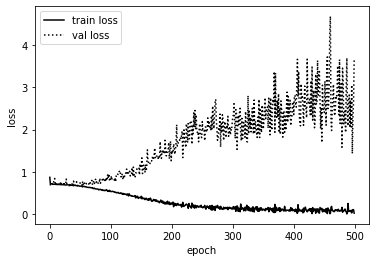

In [ ]:
fig13 = plt.figure()

plt.plot(history.history['loss'],
         label='train loss',
         linestyle = 'solid',
         color = 'black')
plt.plot(history.history['val_loss'],
         label = 'val loss',
         linestyle = 'dotted', 
         color = 'black')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc = 'best')

In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
tf.random.set_seed(0)
model = Sequential()
for _ in range(10):
    model.add(Dense(62,activation = 'selu',
                    kernel_initializer = 'lecun_normal',
                    kernel_regularizer= l2(0.005)))
model.add(Dense(1,activation = 'sigmoid',kernel_regularizer= l2(0.005)))
optimizer = optimizers.RMSprop(learning_rate = 0.001,rho=0.99)
model.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
history_l2 = model.fit(X_train.values,y_train.values,
         epochs = 500, batch_size = 10,verbose = 2,          
         validation_data = (X_val.values,y_val.values))

Epoch 1/500
80/80 - 2s - loss: 3.5124 - accuracy: 0.4800 - val_loss: 3.0057 - val_accuracy: 0.4925 - 2s/epoch - 28ms/step
Epoch 2/500
80/80 - 0s - loss: 2.6984 - accuracy: 0.5475 - val_loss: 2.3912 - val_accuracy: 0.5721 - 248ms/epoch - 3ms/step
Epoch 3/500
80/80 - 0s - loss: 2.1330 - accuracy: 0.5375 - val_loss: 1.8795 - val_accuracy: 0.4975 - 250ms/epoch - 3ms/step
Epoch 4/500
80/80 - 0s - loss: 1.6581 - accuracy: 0.5325 - val_loss: 1.4450 - val_accuracy: 0.5622 - 247ms/epoch - 3ms/step
Epoch 5/500
80/80 - 0s - loss: 1.2843 - accuracy: 0.5337 - val_loss: 1.1304 - val_accuracy: 0.5622 - 223ms/epoch - 3ms/step
Epoch 6/500
80/80 - 0s - loss: 1.0231 - accuracy: 0.5312 - val_loss: 0.9229 - val_accuracy: 0.5622 - 249ms/epoch - 3ms/step
Epoch 7/500
80/80 - 0s - loss: 0.8611 - accuracy: 0.5312 - val_loss: 0.8028 - val_accuracy: 0.5622 - 219ms/epoch - 3ms/step
Epoch 8/500
80/80 - 0s - loss: 0.7718 - accuracy: 0.5312 - val_loss: 0.7398 - val_accuracy: 0.5622 - 246ms/epoch - 3ms/step
Epoch 9/50

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


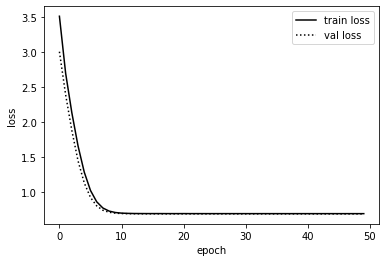

In [ ]:
fig14 = plt.figure()

plt.plot(history_l2.history['loss'][:50],
         label='train loss',
         linestyle = 'solid',
         color = 'black')
plt.plot(history_l2.history['val_loss'][:50],
         label = 'val loss',
         linestyle = 'dotted', 
         color = 'black')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc = 'best')

In [ ]:
score_train = model.evaluate(X_train.values,y_train.values,verbose = 0)
score_val = model.evaluate(X_val.values,y_val.values,verbose = 0)
print('accuracy for train data',score_train[1])
print('accuracy for validation data',score_val[1])

accuracy for train data 0.53125
accuracy for validation data 0.5621890425682068


## ドロップアウト 

In [ ]:
from tensorflow.keras.layers import Dropout

In [ ]:


model = Sequential()
for _ in range(10):
    model.add(Dense(62,activation = 'selu',
                    kernel_initializer = 'lecun_normal'))
    model.add(Dropout(0.5))
model.add(Dense(1,activation = 'sigmoid'))
optimizer = optimizers.RMSprop(learning_rate = 0.001,rho=0.99)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy',
             metrics = ['accuracy'])
history_drop2 = model.fit(X_train.values,y_train.values,
         epochs = 500, batch_size = 10,verbose = 2,          
         validation_data = (X_val.values,y_val.values))



Epoch 1/500
80/80 - 2s - loss: 1.6120 - accuracy: 0.5038 - val_loss: 0.7191 - val_accuracy: 0.4527 - 2s/epoch - 27ms/step
Epoch 2/500
80/80 - 0s - loss: 1.2692 - accuracy: 0.4850 - val_loss: 0.7181 - val_accuracy: 0.4677 - 245ms/epoch - 3ms/step
Epoch 3/500
80/80 - 0s - loss: 1.0799 - accuracy: 0.5013 - val_loss: 0.7098 - val_accuracy: 0.4378 - 222ms/epoch - 3ms/step
Epoch 4/500
80/80 - 0s - loss: 1.0130 - accuracy: 0.4825 - val_loss: 0.6926 - val_accuracy: 0.5124 - 220ms/epoch - 3ms/step
Epoch 5/500
80/80 - 0s - loss: 0.9146 - accuracy: 0.5362 - val_loss: 0.6938 - val_accuracy: 0.5075 - 261ms/epoch - 3ms/step
Epoch 6/500
80/80 - 0s - loss: 0.9024 - accuracy: 0.5075 - val_loss: 0.6895 - val_accuracy: 0.5622 - 218ms/epoch - 3ms/step
Epoch 7/500
80/80 - 0s - loss: 0.8339 - accuracy: 0.5238 - val_loss: 0.6875 - val_accuracy: 0.5622 - 227ms/epoch - 3ms/step
Epoch 8/500
80/80 - 0s - loss: 0.8011 - accuracy: 0.5113 - val_loss: 0.6920 - val_accuracy: 0.5124 - 236ms/epoch - 3ms/step
Epoch 9/50

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


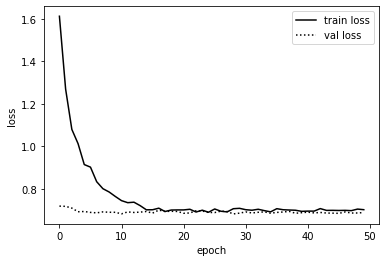

In [ ]:
fig15 = plt.figure()

plt.plot(history_drop2.history['loss'][:50],
         label='train loss',
         linestyle = 'solid',
         color = 'black')
plt.plot(history_drop2.history['val_loss'][:50],
         label = 'val loss',
         linestyle = 'dotted', 
         color = 'black')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc = 'best')

In [ ]:
score_train = model.evaluate(X_train.values,y_train.values,verbose = 0)
score_val = model.evaluate(X_val.values,y_val.values,verbose = 0)
print('accuracy for train data',score_train[1])
print('accuracy for validation data',score_val[1])

accuracy for train data 0.53125
accuracy for validation data 0.5621890425682068
